# Tracking wrinkles in webs
### For questions/concerns contact Robert Hutton, sam@samhutton.net 


- The videos are recorded from an arial perspective, which allows the camera to see the downstream roller and the upstream roller, as well as the "troughs" in-between


- We will be requiring the following libraries:

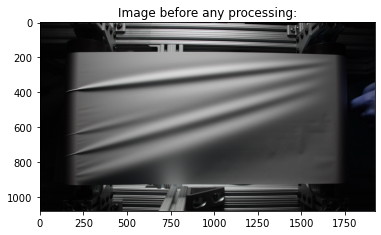

In [250]:
#namespace imports for openCV, pims, and trackpy
import csv
import cv2 as cv
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from pandas import DataFrame, Series
import pims
import trackpy as tp
import moviepy
import skimage.exposure as exposure
from PIL import Image
import seaborn as sns
import glob
import os,sys

#this is a frame from out starting video
example = cv.imread('example.png')
plt.imshow(example,cmap = 'gray') 
plt.title('Image before any processing:')
plt.show()

First, use FFMPEG to slice the video into frames saved as png image files. save to the working directory.

use command: ffmpeg -i input/input.mov -vf fps=1/4 output/%03d.png

change the second "input" to the movie file name.

It is important to note the width of the span in the file name!! since the roller is no longer in the picture as a calibration distance.

- now we apply the above processing steps to all of the images in the series

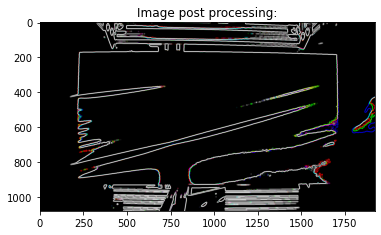

In [251]:
series = sorted(glob.glob("output/*.png"))
i = 0
for image in series:
    i += 1
    img = cv.imread(str(image))
    thresh1 = 75
    img = cv.threshold(img, thresh1, 255, cv.THRESH_BINARY)[1] #convert to binary black and white
    blur = cv.blur(img,(3,3)) #blur with a gaussian

    sobelx = cv.Sobel(src=blur, ddepth=cv.CV_64F, dx=1, dy=0, ksize=15) 
    sobely = cv.Sobel(src=blur, ddepth=cv.CV_64F, dx=0, dy=1, ksize=15)
    sobelxy = cv.Sobel(src=blur, ddepth=cv.CV_64F, dx=1, dy=1, ksize=15) #sobel edge algorithm ie gradients

    sobelx2 = cv.multiply(sobelx,sobelx)
    sobely2 = cv.multiply(sobely,sobely)
    sobel_magnitude = cv.sqrt(sobelx2 + sobely2)
    sobel_magnitude = exposure.rescale_intensity(sobel_magnitude, in_range='image', out_range=(0,255)).clip(0,255).astype(np.uint8) #outputting sobel with scaled exposure

    #since the troughs are still a bit blurry for tracking, implement sharpening by convolving the image with a sharpening kernel, convolved with the image matrix
    kernel = np.array([ [-1,-1,-1], 
                        [-1, 9,-1],
                        [-1,-1,-1]])

    sharpened = cv.filter2D(sobel_magnitude, -1, kernel) # applying the sharpening kernel to the input image & displaying it.

    filename = 'first/output/' + str(image) #declare new filename

    # thresh = 25 #this threshold sets the cutoff for binary b/w, effictively scaling everything above it to max intensity
    # img_binary = cv.threshold(sharpened, thresh, 255, cv.THRESH_BINARY)[1] 

    cv.imwrite('O'+f"{i}.png", sharpened) #write the new image to the directory
    
plt.imshow(sharpened,cmap = 'gray') #plot the last image processed for quick visual check
plt.title('Image post processing:')
plt.show()



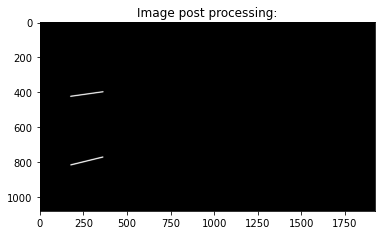

[0.10476190476190476, 0.2474747474747475, 0.1044776119402985, 0.24793388429752067, 0.24888888888888888, 0.10559006211180125, 0.23076923076923078, 0.21160409556313994, 0.09, 0.0891089108910891, 0.21379310344827587, 0.0886426592797784, 0.19642857142857142, 0.08791208791208792, 0.1762917933130699, 0.0896551724137931, 0.17717717717717718, 0.17557251908396945, 0.17632241813602015, 0.16066481994459833, 0.15897435897435896, 0.15835777126099707, 0.1403118040089087, 0.13986013986013987, 0.12300683371298406, 0.12276785714285714, 0.12393162393162394, 0.12280701754385964, 0.24705882352941178, 0.1056338028169014, 0.10476190476190476, 0.1059322033898305, 0.10669456066945607, 0.08879492600422834, 0.0891089108910891, 0.08817635270541083, 0.08739837398373984, 0.234375, 0.08812260536398467, 0.2125, 0.08704061895551257, 0.08705882352941176, 0.08666666666666667, 0.21296296296296297, 0.08668076109936575, 0.211864406779661, 0.07081545064377683, 0.07142857142857142, 0.1926605504587156, 0.06924643584521385, 0

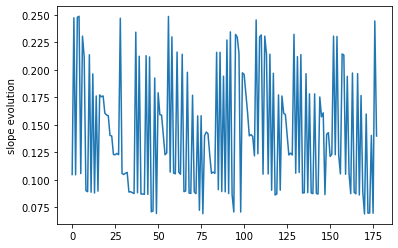

In [260]:
#just a test
series = sorted(glob.glob("output/*.png"))
i = 0
slopes = []
for image in series:
    i += 1
    img = cv.imread(str(image))
    img = cv.blur(img,(3,3)) #blur with a gaussian
    # detect the contours on the binary image using cv2.CHAIN_APPROX_NONE
    img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    edges = cv.Canny(img, 50, 100)
    black = np.zeros((1080,1920,3), np.uint8)
    lines = cv.HoughLinesP(edges, 1, np.pi/180, 85, minLineLength=100, maxLineGap=250)
    # Draw lines on the image
    for line in lines:
        x1, y1, x2, y2 = line[0]
        if y1 > 250 and y1< 850:
            cv.line(black, (x1, y1), (x2, y2), (255, 255, 255), 5)
            slope = ((-1*(y2-y1))/(x2-x1))
            if slope > 0 and slope < 0.25:
                slopes.append(slope)
    # Show result
    cv.imwrite('O'+f"{i}.png", black) #write the new image to the directory
    
plt.imshow(black,cmap = 'gray') #plot the last image processed for quick visual check
plt.title('Image post processing:')
plt.show()
print(slopes)


plt.plot(slopes)
plt.ylabel('slope evolution')
plt.show()

In [253]:
# series2 = sorted(glob.glob("O*.png"))
# i = 0
# for image in series2:
#     i += 1
#     img = cv.imread(str(image))
#     crop = cv.hconcat((img[200:900, 175:200], img[200:900, 800:825], img[200:900, 1725:1750]))
#     img5 = cv.cvtColor(crop, cv.COLOR_BGR2GRAY)
#     filename = 'first/output/' + str(image) #declare new filename

#     # thresh = 25 #this threshold sets the cutoff for binary b/w, effictively scaling everything above it to max intensity
#     # img_binary = cv.threshold(sharpened, thresh, 255, cv.THRESH_BINARY)[1] 

#     cv.imwrite('A'+f"{i}.png", img5) #write the new image to the directory
    
# plt.imshow(img5,cmap = 'gray') #plot the last image processed for quick visual check
# plt.title('Image post processing:')
# plt.show()

Now we may use trackpy to begin distinguishing features in the span

In [254]:
# frames = pims.open('A*.png')
# plt.imshow(frames[0])
# f = tp.batch(frames, 15, minmass=25)
# tp.annotate(f, frames[15])

In [255]:
# #check for accuracy
# tp.subpx_bias(f)

In [256]:
# t1 = tp.link(f, 150, memory=2)
# print(t1.head())

# # Compare the number of particles in the unfiltered and filtered data.
# print('Before:', t1['particle'].nunique())
# t1 = tp.filter_stubs(t1, 2)
# print('After:', t1['particle'].nunique())

# tp.annotate(f, frames[0])
# plt.figure()
# tp.mass_size(t1.groupby('particle').mean()); # convenience function -- just plots size vs. mass
# plt.figure()

# # t1 = t1[((t1['y'] > 200) & (t1['y'] < 850) & (t1['x'] > 120) & (t1['x'] < 1750))] #filter the array by y position
# # tp.annotate(t1[t1['frame'] == 0], frames[0])
# # plt.figure()
# # tp.mass_size(t1.groupby('particle').mean()); # convenience function -- just plots size vs. mass
# # plt.figure()

# # t1 = t1[(t1['mass'] > 1)] #filter the array by mass
# # tp.annotate(t1[t1['frame'] == 0], frames[0])
# # plt.figure()
# # tp.mass_size(t1.groupby('particle').mean()); # convenience function -- just plots size vs. mass
# # plt.figure()

# plt.figure()
# tp.plot_traj(t1)